# Diagnoses analyses
Diagnoses are the leafs of the decision tree underlying DYNAMCic's CDSS. This analysis' aim is twofold:
1. examine if diagnoses are missing in the decision tree?
2. examine if patients are correctly diagnosed?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sb

# import and preprocess symptoms and diagnoss

## get symptoms

In [2]:
# import cleaned and prepared data of consultations in RW
rw_data = pd.read_pickle("data/rw-cleaned-prepared-dynamic-data-phase1.pickle")

In [3]:
# faturs
demographic_columns = [
    #"patient_id",
    "patient_age",
    "patient_gender"
]

# selected based on domain experts
symptoms_of_interest = ["PE212 - Respiratory rate (breaths/min) - 8469",
    "S39 - Cough - 7817", 
    "PE18 - Chest indrawing - 7811",
    "S180 - How is the infant feeding currently? - 7516",
    "S46 - Convulsions in present illness - 8355",
    "BC - Axillary temperature - 7823 categorical",
    "PE125 - Observation of movement - 8388",
    "S96 - Unable to drink or breastfeed - 7871",
    "S157 - Vomiting everything - 8026",
    "OS9 - Unconscious or Lethargic (Unusually sleepy) - 7378",
    "PE63 - Stiff neck - 8391",
    "PE19 - Stridor in calm child - 7812",
    "S42 - Duration of fever (days) - 7819 categorical",
    "S124 - Significant weight loss - 7539",
    "S118 - Significant hemoptysis (>1 episode) - 7941",
    "S176 - Cough duration (days) - 7731 categorical",
    "E46 - Recent close contact with somebody with TB - 7820",
    "PE220 - Identifiable source of fever? - 8399",
    "A55 - Urinary dipstick - 7648",
    "PE134 - Measles rash and associated signs - 8386",
    "PE109 - Scarlet fever rash - 8344",
    "PE106 - Non specific viral rash - 7930",
    "PE218 - Unexplained bleeding - 8107",
    "S153 - Diarrhea (stools are looser or more watery than normal) - 7649",
    "S98 - Number of loose or liquid stools over the past 24 hours - 7882 categorical",
    "S149 - Yellow appearing skin or eyes (jaundice) - 7630",
    "PE191 - Jaundice - 8036",
    "S74 - Abnormal vaginal discharge - 8377",
    "S81 - Urethral discharge - 7810",
    "S79 - Genital lesion - 7867",
    "BC7 - Weight for age (z-score) - 8434 categorical",
    "BC95 - Weight for height - 7451 categorical",
    "BC61 - MUAC for age z-score - 7839 categorical"#formr: "BC - MUAC in cm - 7833 categorical"
]

# add symptoms which appear in several columns because they are actually diagnoses
symptoms_to_find = ["fever without source: presumed bacterial infection", "fever without source: presumed viral illness", "suspicion of tuberculosis"]
symptoms_to_add = [s for symp in symptoms_to_find for s in rw_data.columns if symp in s]
print("Adding the following", len(symptoms_to_add), "symptoms to symptoms_of_interest:\n", symptoms_to_add)
symptoms_of_interest = symptoms_of_interest + symptoms_to_add

Adding the following 12 symptoms to symptoms_of_interest:
 ['DF130 - fever without source: presumed bacterial infection - 30851', 'DF - fever without source: presumed bacterial infection - 26194', 'DF130 - fever without source: presumed bacterial infection - 8480', 'DF130 - fever without source: presumed bacterial infection - 30602', 'DF129 - fever without source: presumed viral illness - 30853', 'DF - fever without source: presumed viral illness - 26192', 'DF129 - fever without source: presumed viral illness - 8481', 'DF129 - fever without source: presumed viral illness - 30604', 'DF9 - suspicion of tuberculosis - 30886', 'DF - suspicion of tuberculosis - 26232', 'DF9 - suspicion of tuberculosis - 8539', 'DF9 - suspicion of tuberculosis - 30643']


In [4]:
# select features for clustering
data = rw_data[np.concatenate((demographic_columns, symptoms_of_interest))]

# engineer malaria feature based on instructions of domain experts
data["malaria"] = rw_data["A50 - Microscopy for malarial parasites - 7837 categorical"]#[e if e == np.nan else rw_data["A51 - Malaria rapid diagnostic test - 7838 categorical"][i] for i, e in enumerate(rw_data["A50 - Microscopy for malarial parasites - 7837 categorical"])]
data.loc[data["malaria"].isna(), "malaria"] == rw_data.loc[data["malaria"].isna(), "A51 - Malaria rapid diagnostic test - 7838 categorical"]

# number of consultation which have no value in "A50 - Microscopy for malarial parasites - 7837 categorical" but a value in "A50 - Microscopy for malarial parasites - 7837 categorical"
sum(rw_data["A50 - Microscopy for malarial parasites - 7837 categorical"].isna() & ~rw_data["A50 - Microscopy for malarial parasites - 7837 categorical"].isna())

# engineer diagnoses features: 
# get features which are diagnosis, merge them and add replace them with merged and final feature
list_diagnoses_as_features = [col for col in data.columns if col[0:2] == "DF"]
diagnoses_data_as_features = data[list_diagnoses_as_features]
diagnoses_data_as_features.columns = [col.split(" - ")[1] for col in diagnoses_data_as_features.columns]
diagnoses_data_as_features = diagnoses_data_as_features.groupby(diagnoses_data_as_features.columns, axis=1, dropna=False).sum(min_count=1)

data = data[[col for col in data.columns if not (col in list_diagnoses_as_features)]] # remove old diagnoses features

# add final and merged diagnoses features
for col in diagnoses_data_as_features.columns:
    data[col] = diagnoses_data_as_features[col]

# normalize NAN values in data
data = data.apply(lambda x : x.replace({
    "not_available": np.nan, 
    'Test/Assessment is unavailable': np.nan, # for malaria feature
    'Unavailable': np.nan
    }), 
    axis=1
)

# convert to float if possible
data = data.astype(float, errors="ignore")

C:\Users\sidla\AppData\Local\Temp\ipykernel_21984\379360076.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["malaria"] = rw_data["A50 - Microscopy for malarial parasites - 7837 categorical"]#[e if e == np.nan else rw_data["A51 - Malaria rapid diagnostic test - 7838 categorical"][i] for i, e in enumerate(rw_data["A50 - Microscopy for malarial parasites - 7837 categorical"])]


## get diagnoses

In [5]:
diagnoses_to_consider = ["Abortion",
   "Abscess",
   "Acute diarrhea",
   "Acute limp or joint pain",
   "Acute otitis media (ear infection)",
   "Allergic conjunctivitis",
   "Anaphylaxis",
   "Bacterial acute pharyngitis",
   "Bacterial conjunctivitis",
   "Bacterial conjunctivitis (< 5 y)",
   "Bacterial pneumonia",
   "Balanitis",
   "Bronchial asthma",
   "Burn",
   "Cellulitis",
   "Chronic ear infection",
   "Chronic limp or joint pain",
   "CNS Danger signs",
   "Common Cold",
   "Complicated abscess",
   "Complicated acute ear infection",
   "Complicated cellulitis",
   "Complicated chicken pox",
   "Complicated deep wound",
   "Complicated impetigo",
   "Complicated neck mass",
   "Complicated prolonged fever",
   "Complicated severe acute malnutrition",
   "Complicated superficial wound",
   "Concern for congenital syndrome or malformation",
   "Confirmed dislocation",
   "Congenital condition",
   "Congenital muscular torticollis",
   "Conjunctivitis",
   "Constipation",
   "Contusion",
   "Convulsions",
   "Corneal abrasion",
   "Critical illness",
   "Dental abscess",
   "Dental emergency",
   "Diaper rash",
   "Diarrhea with no dehydration",
   "Diarrhea with severe dehydration",
   "Diarrhea with some dehydration",
   "Dysentery",
   "Dysentery (Bloody diarrhea)",
   "Ear infection (otitis), acute",
   "Ear infection (otitis), chronic",
   "Eczema (Atopic dermatitis)",
   "Emergency / danger signs",
   "Epilepsy",
   "Extensive folliculitis",
   "Eye disease, infectious",
   "Eye disease, non-infectious",
   "Febrile urinary tract infection",
   "Feeding problem",
   "Feeding problem (Insufficient feeds)",
   "Feeding problem (lack of exclusive breastfeeding)",
   "Feeding problem (lactation)",
   "Fever without source",
   "Folliculitis",
   "Follow-up consultation",
   "Foreign body in ear",
   "Fracture",
   "Generalized (extensive) tinea corporis",
   "Heat rash",
   "Herpes simplex - Oral lesions (herpes labialis)",
   "HIV exposed",
   "Hyperglycemia",
   "Hypoglycemia",
   "IMCI Anemia",
   "IMCI Severe Anemia",
   "IMCI/IMAI pneumonia",
   "Improved conjunctivitis",
   "Influenza",
   "Inguinal hernia",
   "Intestinal parasites",
   "Intestinal parasitic infection: Nematode",
   "Intestinal parasitic infection: Protozoa",
   "Local skin infection",
   "Loss of appetite",
   "Low weight for age",
   "Lower urinary tract infection (cystitis)",
   "Major burn",
   "Major head injury",
   "Major trauma",
   "Malaria",
   "Mastitis",
   "Mastoiditis",
   "Measles",
   "Meningitis",
   "Mild croup",
   "Mild/Moderate anemia",
   "Minor burn",
   "Minor head injury",
   "Moderate head injury",
   "Moderate malnutrition",
   "Molluscum contagiosum",
   "Mumps",
   "Neonatal conjunctivitis - (includes possible gonococcal / chlamydia infection )",
   "Neonatal sepsis",
   "Non-severe abdominal condition",
   "Non-severe headache",
   "Non-severe measles",
   "Non specific viral rash",
   "Omphalitis",
   "Omphalitis complicated / severe",
   "Oral aphthous ulcers",
   "Oral candidiasis",
   "Oral thrush",
   "Orbital cellulitis",
   "Osteomyelitis / septic arthritis",
   "Osteomyelitis/septic arthritis",
   "Oxyuriasis (rectal symptoms/worms in stool)",
   "Pathologic-prolonged jaundice",
   "Pathologic-severe jaundice",
   "Pediculosis (Head lice)",
   "Pelvic Inflammatory disease",
   "Persistent diarrhea",
   "Physical trauma",
   "Physiologic rash : Erythema toxicum",
   "Physiologic rash : transient neonatal pustural melanosis",
   "Physiological jaundice",
   "Pityriasis versicolor",
   "Pneumonia",
   "Pneumonia, non-severe",
   "Pneumonia, severe",
   "Preseptal cellulitis",
   "Primary Syphilis",
   "Prolonged fever",
   "Pyelonephritis",
   "Reactive airway disease",
   "Respiratory tract infection (viral suspected)",
   "Road traffic accident",
   "Scabies",
   "Scarlet fever",
   "Severe abdominal condition",
   "Severe abdominal condition (possible bowel obstruction / hernia / appendicitis)",
   "Severe abdominal problem",
   "Severe anemia",
   "Severe Clinical infection or Severe illness",
   "Severe Croup",
   "Severe dehydration",
   "Severe eye disease",
   "Severe eye problem",
   "Severe malaria",
   "Severe malnutrition",
   "Severe pneumonia",
   "Severe skin infection",
   "Sexually transmitted infection (STI)",
   "Sickle cell disease",
   "Significant hemoptysis",
   "Simple abscess",
   "Skin Condition, non-infectious",
   "Skin infection, fungal",
   "Skin infection, non-fungal",
   "Some dehydration",
   "STI Genital discharge syndrome",
   "Suspected malaria",
   "Suspected severe malaria",
   "Suspected testicular torsion",
   "Suspicion of foreign object in airways",
   "Suspicion of fracture/dislocation",
   "Suspicion of meningitis",
   "Suspicion of poisoning",
   "Suspicion of tuberculosis",
   "Tinea capitis",
   "Tinea corporis",
   "Tooth pain",
   "Typhoid Fever",
   "Uncomplicated acute ear infection",
   "Uncomplicated cellulitis",
   "Uncomplicated chicken pox",
   "Uncomplicated deep wound",
   "Uncomplicated impetigo",
   "Uncomplicated infectious lymphadenitis",
   "Uncomplicated lymphadenopathy",
   "Uncomplicated Malaria",
   "Uncomplicated severe acute malnutrition",
   "Uncomplicated superficial wound",
   "Uncomplicated suspicion of poisoning",
   "Uncomplicated vomiting",
   "Upper respiratory infection",
   "Urinary tract infection (UTI)",
   "Urticaria",
   "Vaginal candidiasis",
   "Vaginal discharge syndrome (Presumed Gonorrhea/ Chlamydia / Trichomoniasis / Bacterial Vaginosis)",
   "Very low weight for age",
   "Very severe febrile disease",
   "Viral acute pharyngitis",
   "Viral conjunctivitis",
   "Viral conjunctivitis (< 5y)",
   "Viral pneumonia",
   "Vulvovaginitis",
   "Wound"]
diagnoses_of_interest = [col for n in diagnoses_to_consider for col in rw_data.columns if (n.lower() in col) & (col[0:2] == "DF") & (~(col in symptoms_of_interest))]
print("number of diagnoses of interest:", len(diagnoses_of_interest))

number of diagnoses of interest: 1169


In [6]:
# get diagnosed diagnoses
raw_rw_diagnoses = rw_data[diagnoses_of_interest]
raw_rw_diagnoses = raw_rw_diagnoses.dropna(axis=1, how='all') # drop diagnoses which were not diagnosed once

# normalize: Accepted = 1, Rejected = 0, NAN = 0, assume doctor's diagnosis = CDSS's diagnosis (= "Manually added": 1)
raw_rw_diagnoses = raw_rw_diagnoses.apply(lambda x : x.replace({"Accepted": 1, "Rejected": 0, "Manually added": 1}), axis=1) 


# merge diagnoses that are separated over several columns 
# (e. g. DF9 - suspicion of tuberculosis – 30886, DF - suspicion of tuberculosis – 26232 are two columns for the same diagnosis)
list_diagnoses = [d.split(" - ")[1] for d in raw_rw_diagnoses.columns]
rw_diagnoses = raw_rw_diagnoses.groupby(list_diagnoses, axis=1, dropna=False).sum(min_count=1) #min_count=1 ensures that sum of only NAN is NAN and that same diagnoses are correctly merged

# NAN = Rejected = 0
rw_diagnoses = rw_diagnoses.fillna(0)

# summarize diagnoses used for further analysis
print("After cleaning and merging columns of the same diagnosis,", rw_diagnoses.shape[1], "diagnoses are considered. Before there were", raw_rw_diagnoses.shape[1], "diagnoses.")

# find diagnoses that were merged and summed together so that value is bigger than 1 (and thus not binary anymore)
for c in rw_diagnoses.columns:
    if(all(val > 1.0 for val in rw_diagnoses[c].unique())):
        print(c+":", rw_diagnoses[c].unique())
        
# check if all diagnoses are binary
binary_rw_diagnoses = rw_diagnoses.nunique(dropna=True).loc[lambda x : x <= 2].index
print("Percentage binary diagnoses:", len(binary_rw_diagnoses)/rw_diagnoses.shape[1])

# print non binary diagnosis
for non_binary_diagnosis in [c for c in rw_diagnoses.columns if not c in binary_rw_diagnoses]:
    print(non_binary_diagnosis+":", rw_diagnoses[non_binary_diagnosis].unique())

After cleaning and merging columns of the same diagnosis, 169 diagnoses are considered. Before there were 627 diagnoses.
Percentage binary diagnoses: 1.0


# General analyses of diagnoses

In [7]:
# top 10 most common diagnoses
top10_diagnoses = rw_diagnoses.sum().sort_values(ascending=False).to_frame().reset_index().head(10)
top10_diagnoses.columns = ["diagnosis", "number_consultations"]
print("share of top 10 diagnoses:", top10_diagnoses["number_consultations"].sum()/rw_diagnoses.shape[0])
fg = px.bar(top10_diagnoses, x="diagnosis", y="number_consultations" )
fg.show()

share of top 10 diagnoses: 0.9003884225034456


In [8]:
# identified symptoms per diagnosis part of top 10

In [9]:
# top 10 most common pairs of diagnoses

In [10]:
# top 10 most common tri-pairs of diagnoses

# Are diagnoses missing - i.e. is the decision tree of DYNAMiC's CDSS complete?
Methodology:
1. filter for patients diagnosed with at last one of the top 10
2. cluster them into 10-20 groups based on their demographics (age, gender) and symptoms as features
3. examine diagnoses per cluster: clusters decided by one diagnoses particularly?
4. examine symptoms per cluster:
    - do symptoms in cluster match the diagnosis of the same cluster found in step before? --> Are patients correctly assigned to diagnoses?
    - do clusters not assignable to diagnoses in step before have symptoms that indicate a diagnoses that has been missed by the decision tree?

Note: [read](https://christophm.github.io/interpretable-ml-book/) on SHAP values for better interpretation

In [11]:
# distribution "number of top 10 diagnoses per consultation" 
number_top10_diagnoses_per_consultation = rw_diagnoses[top10_diagnoses["diagnosis"]].sum(axis=1).value_counts().to_frame().reset_index()
number_top10_diagnoses_per_consultation.columns = ["number diagnoses per consultation", "count"]
fg = px.bar(number_top10_diagnoses_per_consultation, x="number diagnoses per consultation", y="count", title="distribution 'number of top 10 diagnoses per consultation'" )
fg.show()

In [12]:
#filter for patients diagnosed with at last one of the top 10
idx_consultations_with_top10_diagnoses = rw_diagnoses[top10_diagnoses["diagnosis"]].sum(axis=1) > 0
consultations_with_top10_diagnoses = rw_diagnoses[idx_consultations_with_top10_diagnoses]
print("share of consultations with at least one top 10 diagnosis:", consultations_with_top10_diagnoses.shape[0]/rw_diagnoses.shape[0], "--> n =", consultations_with_top10_diagnoses.shape[0])

share of consultations with at least one top 10 diagnosis: 0.48421250469865934 --> n = 23187


## cluster consultations with at least one top 10 into 10-20 groups based on their demographics (age, gender) and symptoms as features
- preprocess
    - one hot encode non-numerical features (binary, categorical) - maintaining NAN as category
    - impute NAN values of numerical features (binary/categorical: median, continues: mean)
    - scale numerical features to avoid favouring of higher magnitude features in euclidian distance
- cluster with k-means - k = 10
- 

In [13]:
from sklearn.preprocessing import MinMaxScaler # alternatively one could use StandardScaler but with MinMaxScaler outliers maintain their significance

# get features for clusterng
features = data[idx_consultations_with_top10_diagnoses]
preprocessed_features = features

# impute numerical features with mean 
# assume: numerical --> continunues
numerical_features = [preprocessed_features.dtypes.index[i] for i, e in enumerate(preprocessed_features.dtypes) if e == "float64"]
for f in numerical_features:
    mean = np.mean(preprocessed_features[f])
    preprocessed_features.loc[preprocessed_features[f].isna(), f] = mean

# stringify NAN values in all other features making it an additional category
preprocessed_features = preprocessed_features.fillna("NaN") 

# scale numerical features to avoid favouring of features in euclidian distance
for feature in numerical_features:
  min_max_scaler = MinMaxScaler() # TODO try from sklearn.preprocessing import StandardScaler on ALLL features
  preprocessed_features[[feature]] = min_max_scaler.fit_transform(preprocessed_features[[feature]])

# one hot encode all non-numerical features
non_numerical_features = [preprocessed_features.dtypes.index[i] for i, e in enumerate(preprocessed_features.dtypes) if e != "float64"]
for feature in non_numerical_features:
    encoded_feature = pd.get_dummies(preprocessed_features[feature], prefix=feature+"_")
    for new_feature in encoded_feature.columns:
        preprocessed_features[new_feature] = encoded_feature[new_feature]

# drop original columns of non-numerical features
preprocessed_features = preprocessed_features.drop(non_numerical_features, axis=1)

C:\Users\sidla\AppData\Local\Temp\ipykernel_21984\2710960412.py:27: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\sidla\AppData\Local\Temp\ipykernel_21984\2710960412.py:27: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\sidla\AppData\Local\Temp\ipykernel_21984\2710960412.py:27: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragment

In [ ]:
!pip install yellowbrick

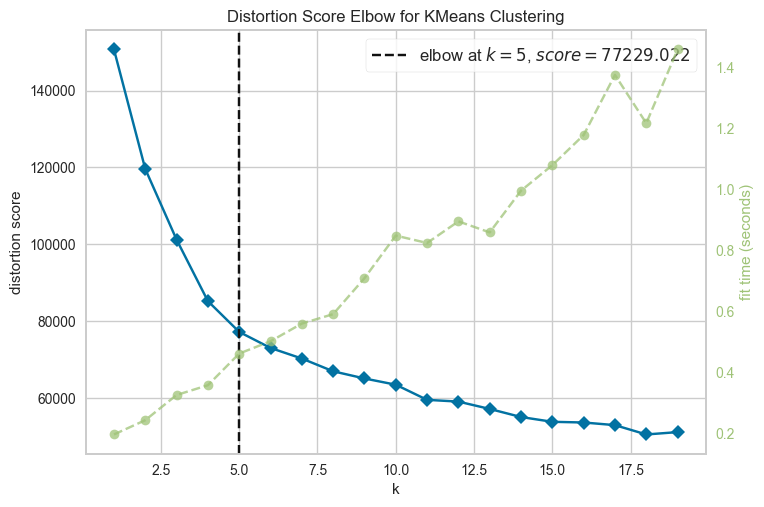

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [14]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Finding the optimal number of clusters using the Elbow method with yellowbrick
model = KMeans(n_init=10)
visualizer = KElbowVisualizer(model, k=(1,20))
visualizer.fit(preprocessed_features)
n_clusters = visualizer.elbow_value_ # optimal number of clusters
visualizer.show()

In [50]:
# cluster with k-means - k = 10
# hyperparam: see here for more info: https://towardsdatascience.com/kmeans-hyper-parameters-explained-with-examples-c93505820cd3
# numbers of clusters, 
# init: approx centroids of each cluster/diagnosis by setting each cluster's centroid close to high values of symptoms underlying the diagnosis -->  issue: clustering algo not generic anymore
# initialization strategy,
# convergence criteria,
# distance metric
kmeans = KMeans(n_clusters=5, n_init=100, random_state=2).fit(preprocessed_features)

# Adding the column 'cluster' to the dataframe
preprocessed_features["cluster"] = kmeans.labels_

## examine diagnoses per cluster: clusters decided by one diagnoses particularly?

In [51]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# get consultatons whch have at least one diagnoss from top 10
diagnoses_per_cluster = rw_diagnoses[top10_diagnoses["diagnosis"]]
diagnoses_per_cluster = diagnoses_per_cluster[idx_consultations_with_top10_diagnoses]

# add cluster result to diagnoses
diagnoses_per_cluster["cluster"] = preprocessed_features["cluster"]
diagnoses_per_cluster = diagnoses_per_cluster.groupby("cluster").sum().reset_index()
diagnoses_per_cluster = pd.melt(
    diagnoses_per_cluster,
    id_vars=["cluster"], 
    value_vars=diagnoses_per_cluster.columns.drop("cluster"),
    var_name="diagnosis", value_name="number_consultations"
)

clusters = sorted(diagnoses_per_cluster["cluster"].unique())

# print diagnoses and the clusters they are in if they are not present in every cluster
diagnoses_cluster_appearance = diagnoses_per_cluster.groupby("diagnosis").size().reset_index(name="number_cluster_appearance")
print("Diagnoses determining clusters:", diagnoses_cluster_appearance[diagnoses_cluster_appearance["number_cluster_appearance"]<len(clusters)])

# plot diagnoses distribution
fig_diagnoses = px.bar(
    diagnoses_per_cluster, 
    x="cluster", 
    y="number_consultations", 
    animation_frame="diagnosis",
    barmode="group", 
    title="Number of consultations with respective diagnosis per cluster",  
)
fig_diagnoses.show()

# plot top 10 diagnosis per cluster and other diagnoses are summarized as "Other"
# create subplots: use 'domain' type for Pie subplot for each cluster
fig = make_subplots(rows=1, cols=len(clusters), specs=[[{'type':'domain'} for c in clusters]])
for cluster in clusters:
    diagnoses_composition = diagnoses_per_cluster.loc[diagnoses_per_cluster["cluster"] == cluster, ["diagnosis", "number_consultations"]].sort_values(by="number_consultations", ascending=False).reset_index(drop=True)
    
    # get only top 10 and compute "other" diagnoses
    sum_other_diagnoses = diagnoses_composition.loc[11:,"number_consultations"].sum()
    diagnoses_composition = diagnoses_composition[:10]
    diagnoses_composition.loc[diagnoses_composition.shape[0]] = {"diagnosis":"other", "number_consultations":sum_other_diagnoses}
    fig.add_trace(
        go.Pie(labels=diagnoses_composition["diagnosis"], values=diagnoses_composition["number_consultations"], name="Cluster "+str(cluster)), 
        1, [int(cluster+1)]
    )

# Use `hole` to create a donut-like pie chart
fig.update_traces(hoverinfo="label+percent+name")

fig.update_layout(
    title_text="Top 10 diagnoses per cluster",
)
fig.show()

Diagnoses determining clusters: Empty DataFrame
Columns: [diagnosis, number_cluster_appearance]
Index: []


CV F1 score of diagnoses based classifier for clustering is 0.5317279937521867


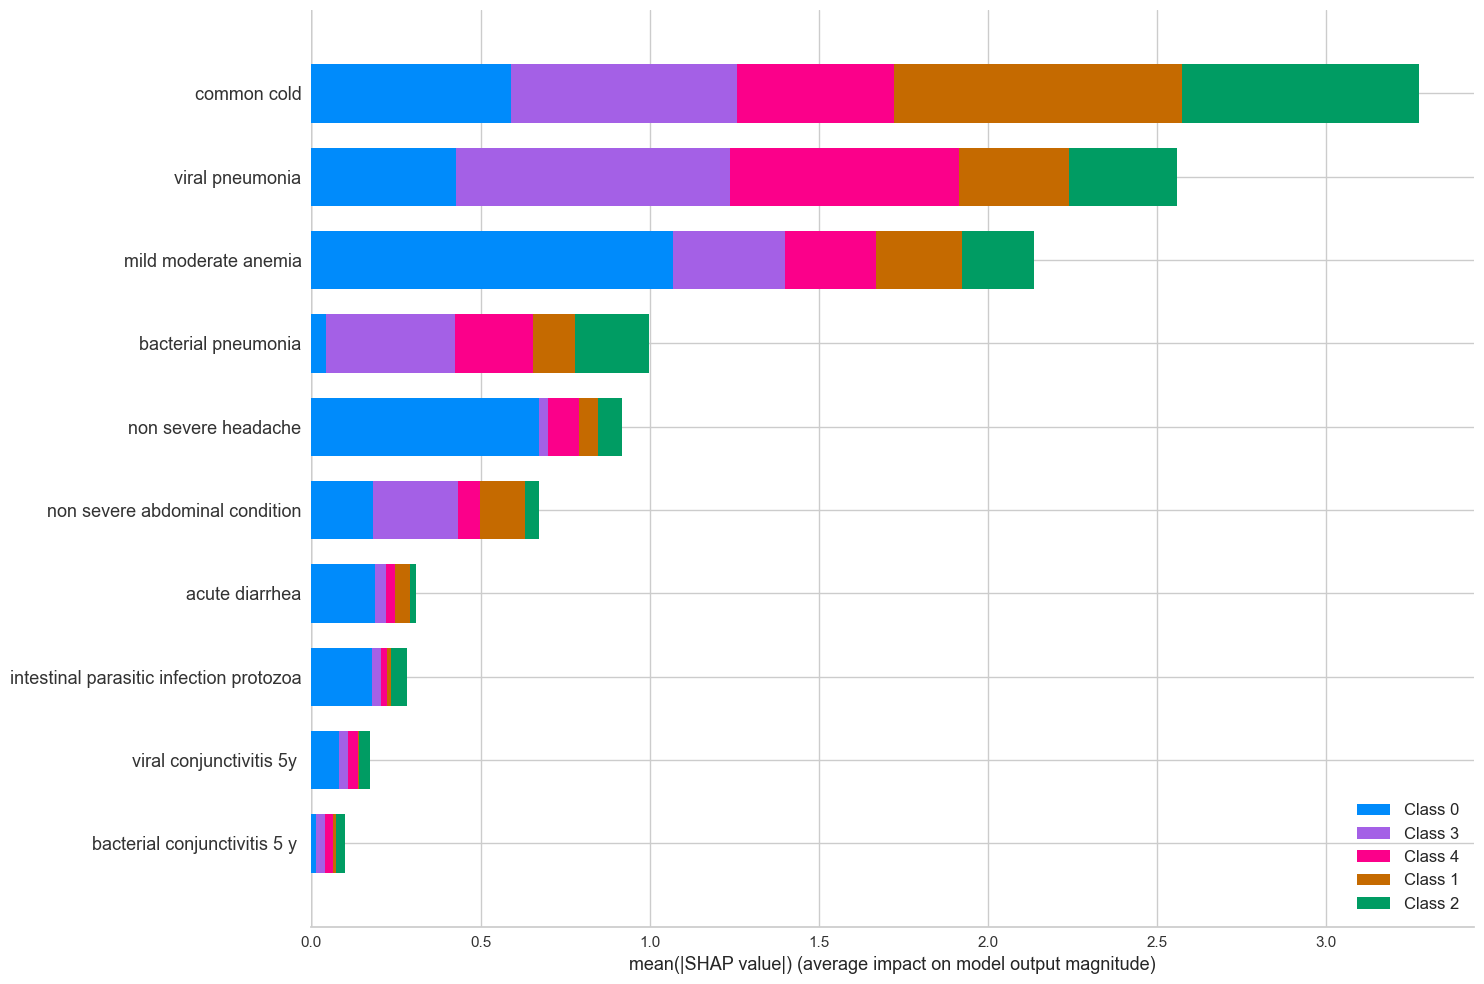

In [52]:
# build lgbm classifier with diagnoses as features to see how well they explain the labels
import lightgbm as lgb # was chosen as mutlinominal regression did not converge and because it is later used due to its advantage of being able to take in categorical values
from sklearn.model_selection import cross_val_score
import shap
import re

# get features for lgbm classifier
diagnoses_features = rw_diagnoses[top10_diagnoses["diagnosis"]]
diagnoses_features = diagnoses_features[idx_consultations_with_top10_diagnoses]

# rename columns so that lgb can read them
diagnoses_features.columns = [re.sub('[^A-Za-z0-9_]+', ' ', c) for c in diagnoses_features.columns]

# get labels
labels = preprocessed_features["cluster"]

# check how good dagnoses explan clusters: the higher F1 the better
clf = lgb.LGBMClassifier() # did not converge: LogisticRegression(multi_class="multinomial", penalty=None, solver="saga", max_iter=1000) 
cv_scores = cross_val_score(clf, diagnoses_features, labels, scoring='f1_weighted')
print(f"CV F1 score of diagnoses based classifier for clustering is {np.mean(cv_scores)}")

# check how diagnoses_features are used to explain the label
clf.fit(diagnoses_features, labels) # fit model

#SHAP values to determine how features are used for classification
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(diagnoses_features)
shap.summary_plot(
    shap_values, 
    diagnoses_features, 
    plot_type="bar", 
    plot_size=(15, 10), 
    title="Average impact of diagnoses on classification of labels from clustering"
)

## examine symptoms per cluster:
- do symptoms in cluster match the diagnosis of the same cluster found in step before? --> Are patients correctly assigned to diagnoses?
- do clusters not assignable to diagnoses in step before have symptoms that indicate a diagnoses that has been missed by the decision tree?

CV F1 score of feature based classifier for clustering is 0.9991375932535442


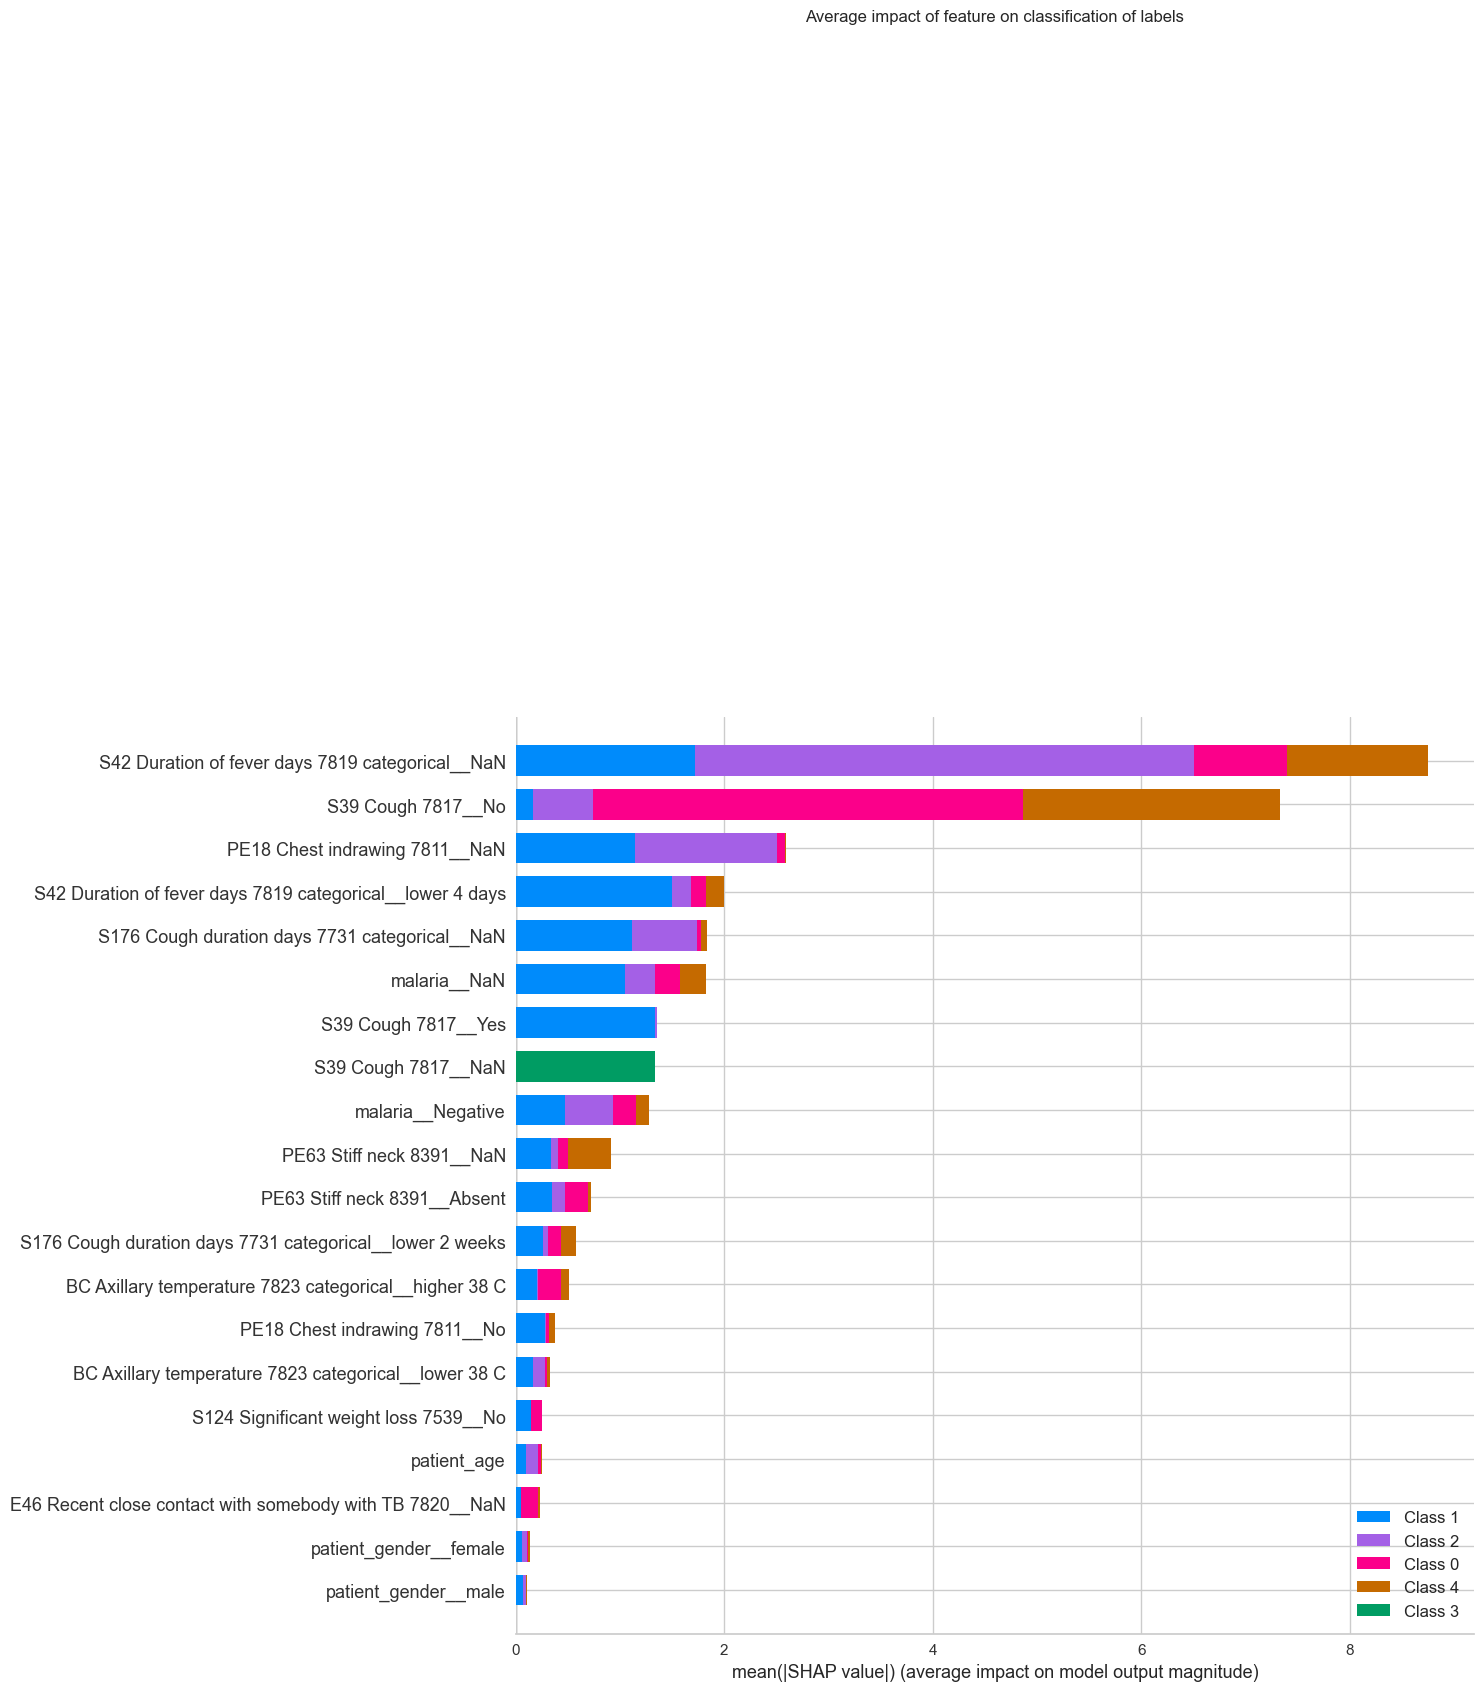

In [49]:
# get how symptoms explain clusters
lgbm_data = preprocessed_features.drop(columns=["cluster"])

# rename columns so that lgb can read them
lgbm_data.columns = [re.sub(r'(>)|(<)', lambda m: 'higher' if m.group(1) else 'lower', c) for c in lgbm_data.columns] # essental to ensure that columns are stll dstnct after next lne of code
lgbm_data.columns = [re.sub('[^A-Za-z0-9_]+', ' ', c) for c in lgbm_data.columns]

# check how good the clusters are: the higher F1 the better
clf = lgb.LGBMClassifier() #colsample_by_tree=0.8
cv_scores = cross_val_score(clf, lgbm_data, labels, scoring='f1_weighted')
print(f"CV F1 score of feature based classifier for clustering is {np.mean(cv_scores)}")

# check how features are used to explain the label
clf.fit(lgbm_data, labels) # fit model

#SHAP values to determine how features are used for classification
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(lgbm_data)
shap.summary_plot(shap_values, lgbm_data, plot_type="bar", plot_size=(15, 10), show=False)
plt.title("Average impact of feature on classification of labels", y=1.75)
plt.show()

# Conclusion